### Logistic Regression models to predict scantool communication success
Various LogisticRegression models to predict success with communications with remote vehicle systems. 

In [191]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

### Import cleaned dataset to be used for building ML Models to predict Scantool success.

In [192]:
diag_usage_df = pd.read_excel('../Data/DiagUsage_Cleaned.xlsx', sheet_name='connect_system')

In [193]:
diag_usage_df.sample(5)

,timestamp,siteId,OsName,client_OS,vin,year,make,model,system,veh_desc,vci_version,scan_method,batt_voltage,result,state,city,product_type,postal_code,system_category
121551,2025-02-07 20:19:28.128,343485,Android,Android 8.1.0,1GCGTEEN6H1,2017,Chevrolet,Colorado,Enhanced Powertrain,2017 Chevrolet Colorado Enhanced Powertrain,22.1.2411.1,quick_scan,14.77,1,IA,Ames,COLLISION,50010-8054,Enhanced Powertrain
86016,2024-11-12 15:13:36.714,742530,Android,Android 8.1.0,1N4BL4CV6PN,2023,Nissan,Altima,Enhanced Powertrain CAN,2023 Nissan Altima Enhanced Powertrain CAN,22.3.2439.2,quick_scan,14.19,1,unknown,unknown,unknown,unknown,Enhanced Powertrain
32908,2024-12-05 19:20:05.896,283869,Windows,Windows 10.0.19045,4T1G11BKXNU,2022,Toyota,Camry,Enhanced Powertrain CAN,2022 Toyota Camry Enhanced Powertrain CAN,22.3.2439.2,quick_scan,13.89,1,GA,SAVANNAH,REPAIR,31408-3024,Enhanced Powertrain
112659,2024-11-15 17:42:44.177,216528,Android,Android 14,1B7KF23601J,2001,Dodge,Cummins,Enhanced Powertrain,2001 Dodge Cummins Enhanced Powertrain,22.1.2418.1,quick_scan,13.57,1,CO,ELIZABETH,REPAIR,80107-7969,Enhanced Powertrain
7970,2024-12-20 17:36:14.965,165349,Android,Android 8.1.0,3D73Y3CL8BG,2011,Dodge,Cummins,Enhanced Powertrain,2011 Dodge Cummins Enhanced Powertrain,21.3.2337.1,quick_scan,14.39,1,CO,Aurora,COLLISION,80011-8002,Enhanced Powertrain


In [194]:
diag_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171215 entries, 0 to 171214
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        171215 non-null  datetime64[ns]
 1   siteId           171215 non-null  int64         
 2   OsName           171215 non-null  object        
 3   client_OS        171215 non-null  object        
 4   vin              171215 non-null  object        
 5   year             171215 non-null  int64         
 6   make             171215 non-null  object        
 7   model            171215 non-null  object        
 8   system           171215 non-null  object        
 9   veh_desc         171215 non-null  object        
 10  vci_version      171215 non-null  object        
 11  scan_method      171215 non-null  object        
 12  batt_voltage     171215 non-null  float64       
 13  result           171215 non-null  int64         
 14  state            171

In [195]:
diag_usage_df.describe().round(2).T

,count,mean,min,25%,50%,75%,max,std
timestamp,171215,2024-12-05 15:26:30.349258496,2024-10-01 20:24:02.463000,2024-11-01 18:45:44.598999808,2024-12-04 16:25:02.011000064,2025-01-09 19:22:35.810000128,2025-02-09 16:28:29.957000,NaN
siteId,171215.0,467281.76,10799.0,258509.0,482188.0,667934.0,888822.0,243428.56
year,171215.0,2017.52,1997.0,2015.0,2018.0,2021.0,2025.0,4.96
batt_voltage,171215.0,12.69,1.48,11.75,12.69,13.78,22.69,1.14
result,171215.0,0.89,0.0,1.0,1.0,1.0,1.0,0.32


#### The baseline performance for success rate is the mean of the result target feature .89

The following features will be removed before training the logistic regression models as they are not useful for predicting the success of scantool communication.<br/> Other features may be removed based on the model being trained. 

- siteId - this is a unique identifier for the site and does not contribute to the prediction of communication success.
- timestamp - this is a time-related feature that does not provide direct information about the communication success.
- OsName - EDA showed this feature does not directly related to the success of scantool communication.
- client_OS - EDA showed this feature does not directly related to the success of scantool communication.
- vin - The VIN contains embedded information that could lead to overfitting. It is also coorelated with other features like make, year, model and system.
- system - The system feature is too manufacturer specific and may lead to overfitting. The system_category will be used instead. 
- veh_desc - The vehicle description is just a concatenation of other features like make, model, year and system.
- state - Geographical features will not be used for initial modeling.
- city - Geographical features will not be used for initial modeling.
- postal_code - Geographical features will not be used for initial modeling.

In [196]:
#remove features that are not useful - none of the models will use these features
features_to_remove = ['siteId', 'timestamp', 'OsName', 'client_OS', 'vin', 'veh_desc', 'state', 'city', 'postal_code']
lgr_model_df = diag_usage_df.drop(features_to_remove, axis = 1)


In [197]:
#year should be a categorical variable for modeling purposes. The age of the vehicle does not affect scanning. 
lgr_model_df['year'] = lgr_model_df['year'].astype(str)

In [198]:
lgr_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171215 entries, 0 to 171214
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   year             171215 non-null  object 
 1   make             171215 non-null  object 
 2   model            171215 non-null  object 
 3   system           171215 non-null  object 
 4   vci_version      171215 non-null  object 
 5   scan_method      171215 non-null  object 
 6   batt_voltage     171215 non-null  float64
 7   result           171215 non-null  int64  
 8   product_type     171215 non-null  object 
 9   system_category  171215 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 13.1+ MB


In [199]:
#create train test split with even result ratio
X_train, X_test, y_train, y_test = train_test_split(lgr_model_df.drop(['result'], axis = 1), lgr_model_df['result'], random_state = 42,
                                                   stratify = lgr_model_df['result'])

### Convenience functions for evaluating models

In [200]:
# Function to create and fit pipeline to encode categorical variable and scale numerical variables for logistic regression model
def Create_and_fit_lgr_pipeline(X_train, y_train):
    # Define the column transformer
    selector = make_column_selector(dtype_include='object')
    transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), selector), remainder=StandardScaler())

    lgr_pipe = Pipeline([('transformer', transformer),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])

    return lgr_pipe

In [201]:
#calculate model scores based on passed in confusion matrix
def calculate_metrics(cm):
  
    # Extract values
    TN, FP = cm[0, 0], cm[0, 1]
    FN, TP = cm[1, 0], cm[1, 1]

    # Calculate metrics safely
    total = TN + FP + FN + TP
    accuracy = (TP + TN) / total if total != 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0  # True positive rate
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # True negative rate
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    f1_score = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0
    npv = TN / (TN + FN) if (TN + FN) != 0 else 0  # Negative predictive value

    total = (total * 100).round(2)
    accuracy = (accuracy * 100).round(2)
    sensitivity = (sensitivity * 100).round(2)  # True positive rate
    specificity = (specificity * 100).round(2)  # True negative rate
    precision = (precision * 100).round(2)
    f1_score = (f1_score * 100).round(2)
    npv = (npv * 100).round(2)  # Negative predictive value
    
    metrics = {
        "accuracy": accuracy,
        "sensitivity (recall)": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1_score": f1_score,
        "negative predictive value": npv
    }
    
    return metrics

In [202]:
def plotConfusionMatrix(cm, name):
    plt.figure(figsize=(6, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [203]:
def Evaluate_model(name, model, x_test, y_test):
    # Generate predictions for the test set
    y_pred = model.predict(x_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(cm)
    print(metrics)
    
    # Plot the confusion matrix
    plotConfusionMatrix(cm, name)
    return metrics

In [204]:
def Evaluate_model_preds(name, y_pred, x_test, y_test):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(cm)
    print(metrics)
    
    # Plot the confusion matrix
    plotConfusionMatrix(cm, name)
    return metrics

In [205]:
#holds model results
model_results = {}

### Base LogisticRegression model
The dataframe to be used for modeling contains a 'system' and 'system_category' feature. These are redundant. Each model will only use one of these.  

Accuracy: 0.89
{'accuracy': 89.32, 'sensitivity (recall)': 99.27, 'specificity': 12.21, 'precision': 89.76, 'f1_score': 94.27, 'negative predictive value': 68.23}


<Figure size 600x400 with 0 Axes>

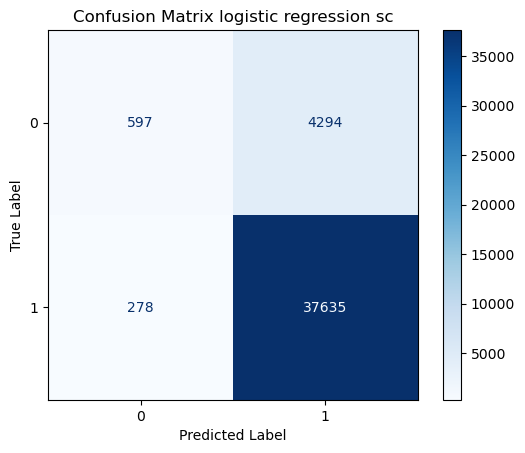

Accuracy: 0.90
{'accuracy': 90.05, 'sensitivity (recall)': 99.38, 'specificity': 17.77, 'precision': 90.35, 'f1_score': 94.65, 'negative predictive value': 78.64}


<Figure size 600x400 with 0 Axes>

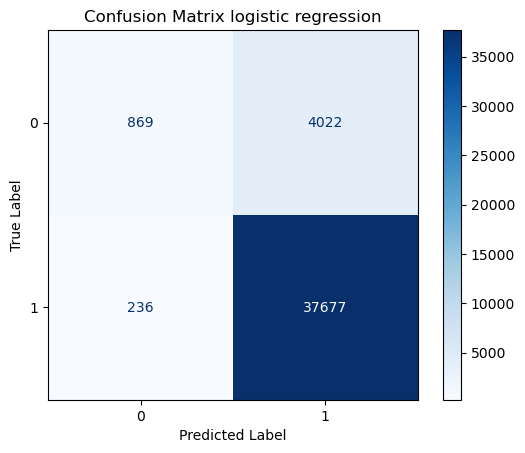

In [206]:
#Create base logistic regression model using system_category as a feature and then system. 
features_to_try = ['system', 'system_category']
for feature_to_remove in features_to_try: 
    if feature_to_remove == 'system_category':
        model_name = 'logistic regression'
    else:
        model_name = 'logistic regression sc'

    lgr_model_base_df = lgr_model_df.drop(feature_to_remove, axis = 1)
    X_train_base = X_train.drop(feature_to_remove, axis = 1)
    X_test_base = X_test.drop(feature_to_remove, axis = 1)

    lgr_base_pipe = Create_and_fit_lgr_pipeline(X_train_base, y_train)
    lgr_base_pipe.fit(X_train_base, y_train)
    metrics = Evaluate_model(model_name, lgr_base_pipe, X_test_base, y_test)
    model_results[model_name] = metrics

### The base model using all systems had slightly better performance than using categorized systems
The remaining models will use system feature and not system_category

### Create model using only intrinsic features of the scantool
The goal of this project is create a model that can be used by customer support to assist customers with scanning issues. The model should be able to help them separate scantool issue from actual vehicle issues. Feature values such as batt_voltage and scan_method may not be available. This model will only use make, model, year, system and vci_version

In [207]:
#remove features that are not useful
features_to_remove = ['system_category', 'scan_method', 'batt_voltage', 'product_type']
lgr_model_intrinsic_df = lgr_model_df.drop(features_to_remove, axis = 1)
X_train_intrinsic = X_train.drop(features_to_remove, axis = 1)
X_test_intrinsic = X_test.drop(features_to_remove, axis = 1)

Accuracy: 0.90
{'accuracy': 90.02, 'sensitivity (recall)': 99.39, 'specificity': 17.34, 'precision': 90.31, 'f1_score': 94.63, 'negative predictive value': 78.66}


<Figure size 600x400 with 0 Axes>

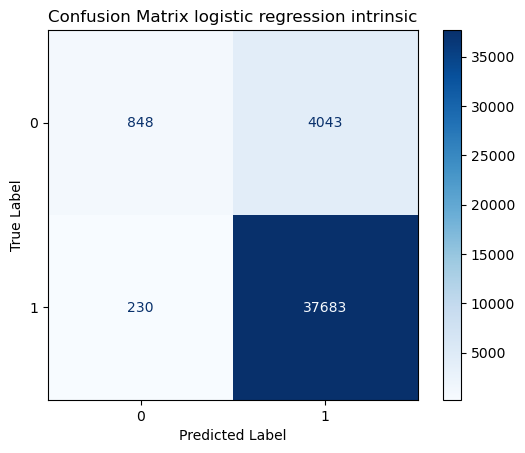

In [208]:
model_name = 'logistic regression intrinsic'
lgr_intrinsic_pipe = Create_and_fit_lgr_pipeline(X_train_intrinsic, y_train)
lgr_intrinsic_pipe.fit(X_train_intrinsic, y_train)
metrics = Evaluate_model(model_name, lgr_intrinsic_pipe, X_test_intrinsic, y_test)
model_results[model_name] = metrics

In [209]:
#Used to plot ROC curves later
y_scores_intrinsic = lgr_intrinsic_pipe.predict_proba(X_test_intrinsic)[:, 1]

### The model using only intrinsic features 'make', 'model', 'year', 'system' and 'vci_version' has slightly better performance than the base model.
The intrinsic features will be used for further analysis and model development.

### Use feature selection to predict features and cross validation to find best hyperparameters. 

In [210]:
#Create pipelines using feature selection methods
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

categorical_features = make_column_selector(dtype_include='object')
transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),remainder=StandardScaler())

# Feature selection using SelectFromModel with LogisticRegression
feature_selector = SelectFromModel(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1.0), 
    threshold='mean'  # Select features with importance above the mean
)

#feature selection using RFE with LogisticRegression
feature_selector_RFE = RFE(estimator=LogisticRegression(random_state=42, max_iter=1000), n_features_to_select=10)

lgr_pipe_feature_selector = Pipeline([('transformer', transformer),
                    ('feature_selection', feature_selector),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])

lgr_pipe_rfe = Pipeline([('transformer', transformer),
                    ('feature_selection', feature_selector_RFE),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters feature selection: {'lgr__C': 1, 'lgr__penalty': 'l1', 'lgr__solver': 'liblinear'}
Accuracy: 0.90
{'accuracy': 90.0, 'sensitivity (recall)': 99.39, 'specificity': 17.24, 'precision': 90.3, 'f1_score': 94.63, 'negative predictive value': 78.49}


<Figure size 600x400 with 0 Axes>

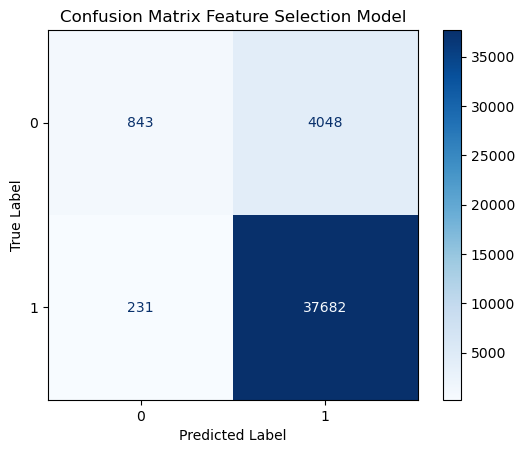

In [211]:
#Perform grid search to find the best parameters for the model with feature selection
from sklearn.model_selection import GridSearchCV
param_grid = {
    #'feature_selection__estimator__C': [0.01, 0.1, 1, 10],
    #'feature_selection__estimator__penalty': ['l1', 'l2'],
    #'feature_selection__estimator__solver': ['liblinear'],
    'lgr__C': [0.01, 0.1, 1, 10],
    'lgr__penalty': ['l1', 'l2'],
    'lgr__solver': ['liblinear'],
}

grid_search_fs = GridSearchCV(lgr_pipe_feature_selector, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_fs.fit(X_train_intrinsic, y_train)

print("Best parameters feature selection:", grid_search_fs.best_params_)
metrics_fs = Evaluate_model('Feature Selection Model', grid_search_fs.best_estimator_, X_test_intrinsic, y_test)
model_results['lg feature selection'] = metrics_fs

In [212]:
# Commented out due to long runtime and lack of significant improvement in results
# Feature selection using RFE with LogisticRegression
#grid_search_rfe = GridSearchCV(lgr_pipe_rfe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
#grid_search_rfe.fit(X_train_intrinsic, y_train)

#print("Best parameters RFE:", grid_search_rfe.best_params_)
#metrics_rfe = Evaluate_model('RFE Model', grid_search_rfe.best_estimator_, X_test_intrinsic, y_test)
#model_results['lgr_rfe'] = metrics_rfe

### Vary the probability thresholds of the Logistic Regression model with intrinsic features only
Try to improve the specificity of the model while keeping F1 score high


In [213]:
y_proba = lgr_intrinsic_pipe.predict_proba(X_test_intrinsic)

thresholds = [0.3, 0.5, 0.7, 0.8, 0.9]
for t in thresholds:
    y_pred = (y_proba[:, 1] >= t).astype(int)
    print(f"Threshold = {t}")
    cm = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(cm)
    print("Metrics:")  
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("\n")

Threshold = 0.3
Metrics:
accuracy: 89.8100
sensitivity (recall): 99.8500
specificity: 11.9800
precision: 89.7900
f1_score: 94.5500
negative predictive value: 91.1400


Threshold = 0.5
Metrics:
accuracy: 90.0200
sensitivity (recall): 99.3900
specificity: 17.3400
precision: 90.3100
f1_score: 94.6300
negative predictive value: 78.6600


Threshold = 0.7
Metrics:
accuracy: 89.1700
sensitivity (recall): 97.0000
specificity: 28.4600
precision: 91.3100
f1_score: 94.0700
negative predictive value: 55.0600


Threshold = 0.8
Metrics:
accuracy: 85.9200
sensitivity (recall): 91.5100
specificity: 42.5900
precision: 92.5100
f1_score: 92.0100
negative predictive value: 39.2800


Threshold = 0.9
Metrics:
accuracy: 68.4000
sensitivity (recall): 68.0500
specificity: 71.1500
precision: 94.8100
f1_score: 79.2300
negative predictive value: 22.3200




In [214]:
#Prebability threshold of 0.7 gave the best results. Add its metrics to the model results.
threshold = 0.7
y_pred = (y_proba[:, 1] >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
metrics = calculate_metrics(cm)
model_results['lgr threshold_0.7'] = metrics

In [215]:
#since all features are categorical directly encode them and skip the pipeline
encoded_df = pd.get_dummies(lgr_model_intrinsic_df.copy()).astype(int)

#Encoded train and test sets will be used for shap analysis
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(encoded_df.drop(['result'], axis = 1), encoded_df['result'], random_state = 42,
                                                   stratify = encoded_df['result'])

In [216]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_encoded, y_train_encoded)

RandomForestClassifier()

Accuracy: 0.91
{'accuracy': 91.46, 'sensitivity (recall)': 98.46, 'specificity': 37.23, 'precision': 92.4, 'f1_score': 95.33, 'negative predictive value': 75.72}


<Figure size 600x400 with 0 Axes>

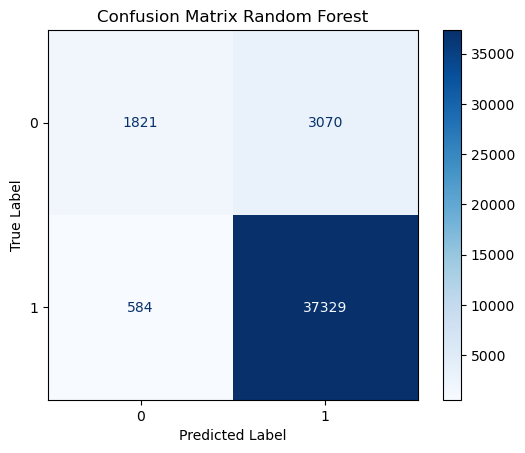

In [217]:
#y_pred_rf = rf_clf.predict(X_test_encoded)
metrics_rf = Evaluate_model('Random Forest', rf_clf, X_test_encoded, y_test_encoded)
model_results['Random Forest'] = metrics_rf

In [218]:
#Will be used to plot ROC curve for random forest model
y_scores_rf = rf_clf.predict_proba(X_test_encoded)[:, 1]

In [219]:
#!pip install xgboost

Accuracy: 0.91
{'accuracy': 90.84, 'sensitivity (recall)': 99.48, 'specificity': 23.88, 'precision': 91.02, 'f1_score': 95.06, 'negative predictive value': 85.51}


<Figure size 600x400 with 0 Axes>

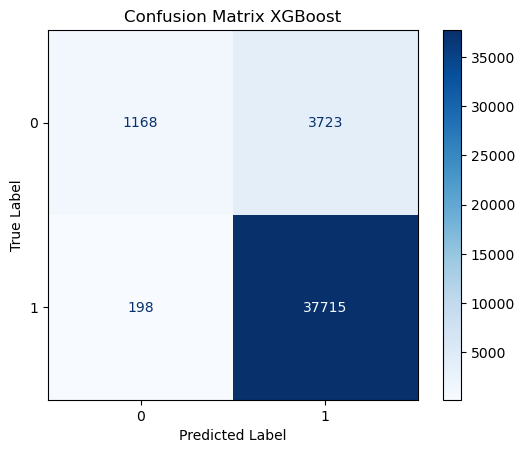

In [221]:
from xgboost import XGBClassifier
from collections import Counter

#counter = Counter(y_train_encoded)
#scale_pos_weight = counter[0] / counter[1]
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
#xgb_clf = XGBClassifier(
#    objective='binary:logistic',
#    eval_metric='logloss',
#    use_label_encoder=False,
#    #scale_pos_weight=scale_pos_weight,  this hurt the model performance drastically
#    max_depth=6,
#    learning_rate=0.1,
#    n_estimators=100,
#    random_state=42
#)

xgb_clf.fit(X_train_encoded, y_train_encoded)

metrics_xgb = Evaluate_model('XGBoost', xgb_clf, X_test_encoded, y_test_encoded)
model_results['XGBoost'] = metrics_xgb


In [222]:
#will be used to Plot ROC curve for XGBoost
y_scores_xgb = xgb_clf.predict_proba(X_test_encoded)[:, 1]

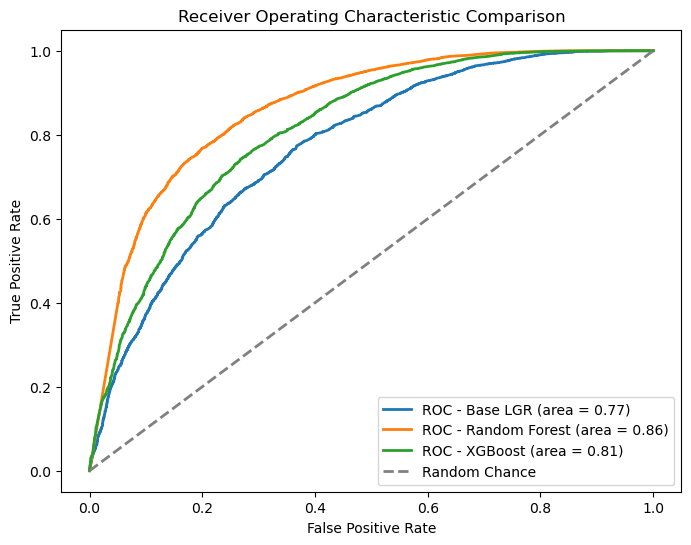

In [223]:
# Calculate ROC AUC for intrinsic model
fpr_intrinsic, tpr_intrinsic, _ = roc_curve(y_test, y_scores_intrinsic)
roc_auc_intrinsic = auc(fpr_intrinsic, tpr_intrinsic)

# Calculate ROC AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Calculate ROC curve and AUC for model2
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_scores_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotting the ROC curves on one plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_intrinsic, tpr_intrinsic, lw=2, label=f'ROC - Base LGR (area = {roc_auc_intrinsic:.2f})')
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'ROC - Random Forest (area = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'ROC - XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc='lower right')
plt.show()

In [224]:
model_results_df = pd.DataFrame(model_results).T
model_results_df

,accuracy,sensitivity (recall),specificity,precision,f1_score,negative predictive value
logistic regression sc,89.32,99.27,12.21,89.76,94.27,68.23
logistic regression,90.05,99.38,17.77,90.35,94.65,78.64
logistic regression intrinsic,90.02,99.39,17.34,90.31,94.63,78.66
lg feature selection,90.00,99.39,17.24,90.30,94.63,78.49
lgr threshold_0.7,89.17,97.00,28.46,91.31,94.07,55.06
Random Forest,91.46,98.46,37.23,92.40,95.33,75.72
XGBoost,90.84,99.48,23.88,91.02,95.06,85.51


In [225]:
#model_results_df.to_excel('model_results.xlsx', index=True)

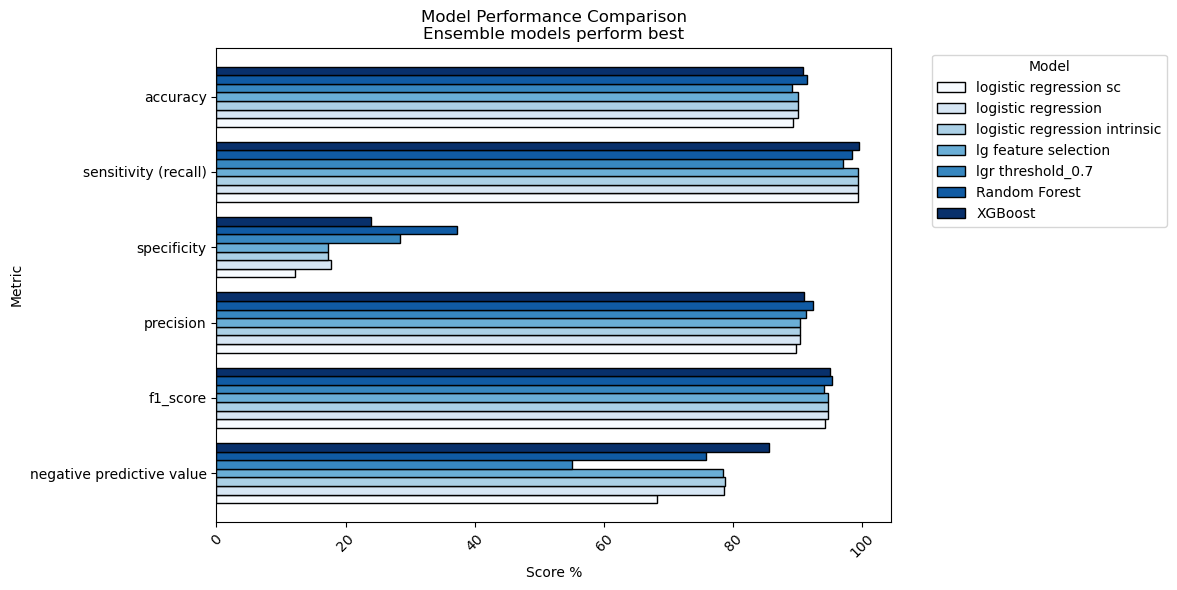

In [226]:
plot_order = ['negative predictive value', 'f1_score', 'precision', 'specificity', 'sensitivity (recall)', 'accuracy']
df_plot = model_results_df[plot_order].T

# Plot
df_plot.plot(kind='barh', figsize=(12, 6), width=0.8, colormap='Blues', edgecolor='black', legend=True)
plt.title("Model Performance Comparison\nEnsemble models perform best")
plt.ylabel("Metric")
plt.xlabel("Score %")
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

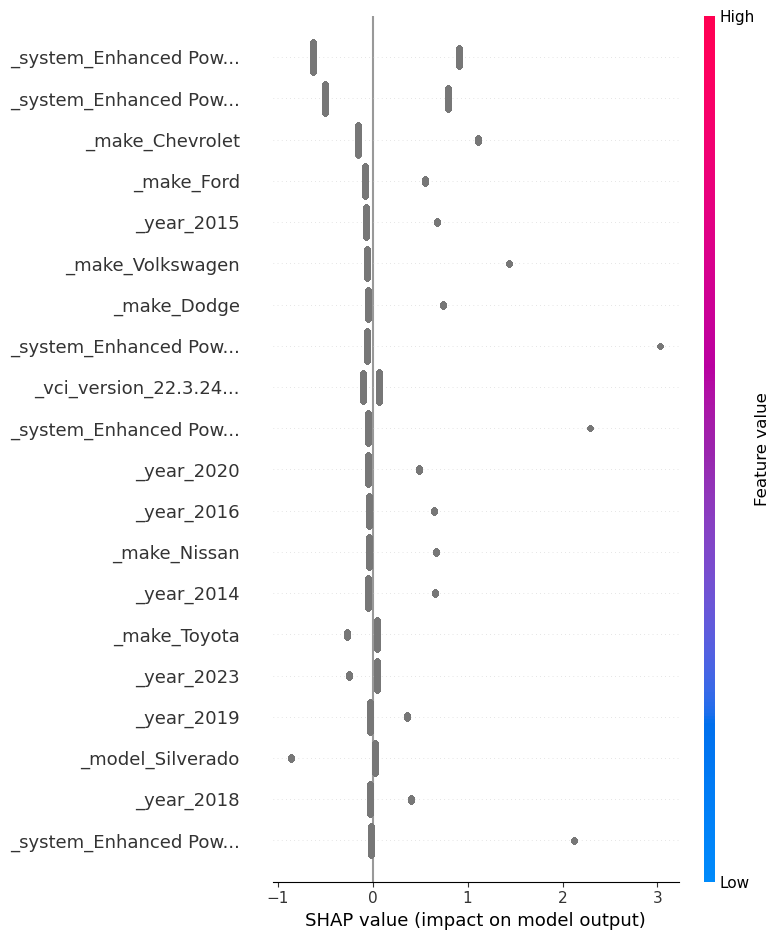

In [227]:
import shap
best_model = lgr_intrinsic_pipe.named_steps['lgr']
X_train_transformed = lgr_intrinsic_pipe.named_steps['transformer'].transform(X_train_intrinsic)
X_test_transformed = lgr_intrinsic_pipe.named_steps['transformer'].transform(X_test_intrinsic)
explainer = shap.LinearExplainer(best_model, X_train_transformed)
shap_values = explainer(X_test_transformed)

feature_names = lgr_intrinsic_pipe.named_steps['transformer'].get_feature_names_out()
truncated_feature_names = [
    (name.replace("onehotencoder_", "") if "onehotencoder_" in name else name)
    for name in feature_names
]
truncated_feature_names = [
    name if len(name) < 20 else name[:20] + '...' for name in truncated_feature_names
]


# Summary Plot
shap.summary_plot(shap_values, X_test_transformed, truncated_feature_names)

### Model Results: 
- Accuracy: All models are high-performing, with accuracies around 89%–90%. The best accuracy is seen in the Random Forest ensemble model.
- Sensitivity (Recall): All models score for Sensitivity is approximately 99% indicating excellent ability to predict if a vehicle scan will be successful.
- Specificity: Low across all models, with the best being 37% with the Random Forest model. This means the model will have a poor ability to detect the which vehicles the scantool will    not scan. From the Logistic Regression models, the model with threshold for success modified to 0.7 had the best Specificity but this resulted in reduced scores for other metrics.   
- Precision: All models have good precision, indicating a high percentage of predicted positives are correct.
- F1 Score: High and consistent across models 94-95%, driven by high recall.
- Negative Predictive Value (NPV): Varies more than other metrics. This is the one category where the XGBoost model outperformed the Random Forest. 

#### Interpretation
All models accurately identify successful scans but have difficulty detecting unsupported vehicles. Adjusting the threshold in the logistic regression model improved its ability to flag unsupported cases. Among the ensemble models, Random Forest performed slightly better than XGBoost. If the model predicts a successful scan, it can be trusted. If the model predicts failure, further investigation will be needed. 

#### Features
Adding features to the model that are not intrinsic to the scantool (such as vehicle battery voltage and product type) did not improve model performance. The final models were trained using Make, Model, Year, System and VCI_Version. This shows that the scanning result data is not being affected by outside factors enough to affect the model. Users of the model will be able to predict the scantools performance using 5 features and will not need hard to obtain information. 
SHAP analysis revealed that using up-to-date VCI software, scanning advanced powertrain systems, and belonging to a top vehicle make were key predictors of scanning success.